In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf

from time import time

from edward.models import (
    Dirichlet, Categorical, ParamMixture)

plt.style.use('ggplot')

In [2]:
def build_toy_dataset(D, V, K):
    """
    Builds a toy dataset of D documents.
    
    Args:
        D - Number of documents
        V - Size of vocabulary
        K - Number of topics
        
    Returns:
        w - List of 1D NumPy arrays containing
            word tokens for each document
        theta - 2D NumPy array containing document
                topic distributions
        phi - 2D NumPy array containing topic
               token distributions
    """
    # Draw number of tokens for each document
    N = np.random.randint(low=100,
                          high=500,
                          size=D)
    
    # Draw topic distributions for each document
    theta = np.random.dirichlet(alpha=np.ones(K) * 0.1, 
                                size=D)

    # Create topics (non-overlapping)
    phi_values = np.array([K * 1 / V] * int(V / K) + [0.0] * int(V - V / K))
    phi = np.zeros([K, V])
    for k in range(K):
        phi[k, :] = np.roll(phi_values, int(k * V / K))
    
    # Draw tokens for each document
    w, z = [0] * D, [0] * D
    for d in range(D):
        # Draw token topic assignments
        z[d] = np.array([np.random.choice(range(K), size=N[d], p=theta[d, :])])[0]
        # Draw tokens
        w[d] = np.zeros(N[d])
        for n in range(N[d]):
            w[d][n] = np.random.choice(range(V), size=1, p=phi[z[d][n], :]) 

    return w, theta, phi

In [3]:
###############
# DATA
###############

# Get toy dataset
D = 10
V = 30
K = 5
w_train, theta_train, phi_train = build_toy_dataset(D, V, K)

In [4]:
# Print topic token distributions
phi_train

array([[ 0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.16666667,
         0.16666667,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.16666667,  0.16666667,  0.16666667,  0.16666667,
         0.16666667,  0.16666667,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0

In [5]:
###############
# MODEL
###############

alpha = tf.ones(K) * 0.1 #Dirichlet param for theta
beta = tf.ones(V) * 0.01 #Dirichlet param for phi

phi = Dirichlet(concentration=beta, 
                 sample_shape=K)

theta, w, z = [None] * D, [None] * D, [None] * D
for d in range(D):
    theta[d] = Dirichlet(concentration=alpha)
    
    # Model each document as a mixture model
    w[d] = ParamMixture(mixing_weights=theta[d], 
                        component_params={'probs': phi},
                        component_dist=Categorical,
                        sample_shape=len(w_train[d]),
                        validate_args=True)
    
    # Pull assignments from mixture model
    z[d] = w[d].cat


In [6]:
####################
#INFERENCE
####################

# Initialize latent variables randomly

sess = ed.get_session()
tf.summary.FileWriter('log', sess.graph) # Log files for Tensorboard

var_dict = {} # Feed dict for tracking initalized variables
print('Initial parameters:\n')

# Initialize phi
phi_est = sess.run(fetches=phi)
var_dict[phi] = phi_est
print('phi:\n{}'.format(phi_est))

theta_est, z_est = [0] * D, [0] * D
for d in range(D):
    # Initialize theta[d]
    theta_est[d] = sess.run(fetches=theta[d], 
                            feed_dict=var_dict)
    var_dict[theta[d]] = theta_est[d]
    print('theta{}:\n{}'.format(d, theta_est[d]))
    
    # Initialize z[d]
    z_est[d] = sess.run(fetches=z[d],
                        feed_dict=var_dict)
    var_dict[z[d]] = z_est[d]
    print('z{}:\n{}'.format(d, z_est[d]))


Initial parameters:

beta:
[[  2.48470060e-37   1.67569735e-15   2.48470060e-37   1.25836008e-08
    3.80530395e-03   1.47395569e-03   2.48470060e-37   2.48470060e-37
    3.75036634e-12   4.29928105e-35   6.03466077e-08   1.10048975e-04
    2.48470060e-37   2.66918182e-01   7.26737678e-01   2.18725438e-30
    3.31942545e-07   2.48470060e-37   2.48470060e-37   2.48470060e-37
    2.48470060e-37   2.48470060e-37   3.51513747e-37   2.48470060e-37
    2.48470060e-37   9.54374904e-04   2.48470060e-37   2.48470060e-37
    2.48470060e-37   2.48470060e-37]
 [  0.00000000e+00   3.61870977e-34   8.91185846e-05   0.00000000e+00
    0.00000000e+00   0.00000000e+00   2.22883804e-28   0.00000000e+00
    2.61620697e-10   0.00000000e+00   0.00000000e+00   3.00723781e-32
    0.00000000e+00   9.93791282e-01   4.99509059e-34   0.00000000e+00
    0.00000000e+00   2.22022345e-38   3.00304885e-11   2.64854380e-03
    1.29729978e-31   0.00000000e+00   7.62784645e-37   7.09403048e-06
    1.82207685e-07   0.000

In [7]:
# Get complete conditionals
phi_cond = ed.complete_conditional(phi)

theta_cond, z_cond = [0] * D, [0] * D
for d in range(D):
    theta_cond[d] = ed.complete_conditional(theta[d])
    z_cond[d] = ed.complete_conditional(z[d])
    
    # Print progress (sometimes this takes a while...)
    print('Completed complete conditions for '
          '{} of {} documents'.format(d + 1, D))
    

Completed complete conditions for 1 of 10 documents
Completed complete conditions for 2 of 10 documents
Completed complete conditions for 3 of 10 documents
Completed complete conditions for 4 of 10 documents
Completed complete conditions for 5 of 10 documents
Completed complete conditions for 6 of 10 documents
Completed complete conditions for 7 of 10 documents
Completed complete conditions for 8 of 10 documents
Completed complete conditions for 9 of 10 documents
Completed complete conditions for 10 of 10 documents


In [9]:
# Bind latent variables to initialzed values
cond_dict = {phi: phi_est}
for d in range(D):
    cond_dict[theta[d]] = theta_est[d]
    cond_dict[z[d]] = z_est[d]
    cond_dict[w[d]] = w_train[d]
    

# Gibbs sampler
start = time() # Track start time
T = 500 # Number of samples
for t in range(T):
    # Sample phi from its complete conditional
    phi_est = sess.run(fetches=phi_cond, 
                       feed_dict=cond_dict)
    
    cond_dict[phi] = phi_est
    
    for d in range(D):
        # Sample z[d] from its complete conditional
        z_est[d] = sess.run(fetches=z_cond[d], 
                            feed_dict=cond_dict)
        
        cond_dict[z[d]] = z_est[d]
        
        # Sample theta[d] from its complete conditional
        theta_est[d] = sess.run(fetches=theta_cond[d], 
                                feed_dict=cond_dict)
        
        cond_dict[theta[d]] = theta_est[d]

    # Print completed every 100 iterations
    if t % 100 == 0:
        print('Completed {} of {} iterations in {:.2f} sec'.format(t, T, time() - start))

print('\nRequired {:.2f} seconds to run {} iterations'.format(time() - start, T))


Completed 0 of 500 iterations in 20.59 sec
Completed 100 of 500 iterations in 30.30 sec
Completed 200 of 500 iterations in 39.91 sec
Completed 300 of 500 iterations in 49.40 sec
Completed 400 of 500 iterations in 59.01 sec

Required 68.46 seconds to run 500 iterations


In [10]:
print('Final sample for parameters: \n')

for d in range(D):
    print('theta{}:\n{}\n'.format(d, theta_est[d]))

print('phi:\n{}'.format(phi_est))
print()

Final sample for parameters: 

theta0:
[  2.19397608e-11   9.99978602e-01   3.26169972e-13   2.13261847e-05
   3.56491867e-08]

theta1:
[  8.82902648e-03   9.91170883e-01   6.46189449e-08   8.18567610e-12
   1.80756980e-17]

theta2:
[  3.22192581e-03   9.94776905e-01   2.59090215e-04   1.74210034e-03
   8.78117401e-09]

theta3:
[  4.83046751e-05   9.99238372e-01   2.63661175e-04   2.84070047e-05
   4.21242876e-04]

theta4:
[  8.46132123e-11   9.98343349e-01   1.17688952e-03   1.83721313e-05
   4.61343909e-04]

theta5:
[  4.16085271e-07   9.99921024e-01   2.67868572e-08   6.94027891e-11
   7.85420343e-05]

theta6:
[  8.80951700e-10   9.99887049e-01   3.11761687e-06   5.02684372e-07
   1.09302593e-04]

theta7:
[  1.07101221e-06   9.99141574e-01   1.57051673e-07   8.48956794e-10
   8.57207808e-04]

theta8:
[  1.59390609e-07   9.98476326e-01   1.76704248e-07   4.70888823e-12
   1.52335409e-03]

theta9:
[  1.02347776e-10   1.00000000e+00   1.07404086e-10   5.89812110e-09
   9.05560738e-10]


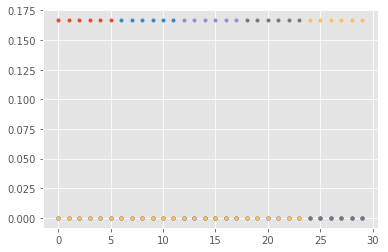

In [11]:
# Plot original topic token distributions
plt.plot(phi_train.T, '.')
plt.show()

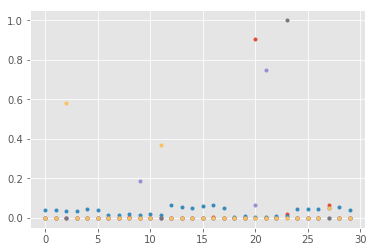

In [12]:
# Plot inferred topic token distributions
plt.plot(phi_est.T, '.')
plt.show()